# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [2]:
# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np

# Library for creating and showing plots
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg

import seaborn as sns

# Importing all the required sub-modules from Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [3]:
#import zipfile

#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Capstone_Project/cell_images.zip", 'r')
#zip_ref.extractall("/content/drive/MyDrive/Capstone_Project/")
#zip_ref.close()


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:
# Parent directory where images are stored in drive
parent_dir = '/content/drive/MyDrive/Capstone_Project/cell_images'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'train')
test_dir = os.path.join(parent_dir, 'test')

# Directory with our training pictures
train_parasitized_dir = os.path.join(train_dir, 'parasitized')
train_uninfected_dir = os.path.join(train_dir, 'uninfected')

# Directory with our testing pictures
test_parasitized_dir = os.path.join(test_dir, 'parasitized')
test_uninfected_dir = os.path.join(test_dir, 'uninfected')

train_parasitized_files = len(os.listdir(train_parasitized_dir))
train_uninfected_files = len(os.listdir(train_uninfected_dir))

test_parasitized_files = len(os.listdir(test_parasitized_dir))
test_uninfected_files = len(os.listdir(test_uninfected_dir))

print('Number of training images parasitized:',train_parasitized_files)
print('Number of training images uninfected:',train_uninfected_files)

print('Number of testing images parasitized:',test_parasitized_files)
print('Number of testing images uninfected:',test_uninfected_files)

Number of training images parasitized: 12582
Number of training images uninfected: 12376
Number of testing images parasitized: 1300
Number of testing images uninfected: 1300


###<b> Check the shape of train and test images

In [6]:
from PIL import Image

train_images=[]
train_class=[]

test_images=[]
test_class=[]

def create_dataset(img_folder):

    for dir in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir)):

            image_path= os.path.join(img_folder, dir,  file)
            image = Image.open(image_path)
          # Resizing each image to (64, 64)
          # image = image.resize((64, 64))
            image=np.array(image)
          # Normalizing the images
          #  image = image.astype('float32')
          #  image /= 255
            if (img_folder.find('train') != -1):
              train_images.append(image)
              if(img_folder.find('train') != -1 and dir == 'parasitized'):
                train_class.append(1)
              if(img_folder.find('train') != -1 and dir == 'uninfected'):
                  train_class.append(0)
            if (img_folder.find('test') != -1):
              test_images.append(image)
              if(img_folder.find('test') != -1 and dir == 'parasitized'):
                test_class.append(1)
              if(img_folder.find('test') != -1 and dir == 'uninfected'):
                  test_class.append(0)


create_dataset(train_dir)
create_dataset(test_dir)

for i in range(0,5):
  print('Shape of Training image ',i,' ',train_images[i].shape)

for i in range(0,5):
  print('Shape of Testing image ',i,' ',test_images[i].shape)

Shape of Training image  0   (154, 160, 3)
Shape of Training image  1   (148, 154, 3)
Shape of Training image  2   (178, 172, 3)
Shape of Training image  3   (142, 148, 3)
Shape of Training image  4   (163, 175, 3)
Shape of Testing image  0   (121, 112, 3)
Shape of Testing image  1   (151, 157, 3)
Shape of Testing image  2   (121, 148, 3)
Shape of Testing image  3   (118, 118, 3)
Shape of Testing image  4   (118, 100, 3)


###<b> Check the shape of train and test labels

In [7]:
train_images = np.array(train_images,dtype=object)
train_class = np.array(train_class)

test_images = np.array(test_images,dtype=object)
test_class = np.array(test_class)

print('Shape of train images:',train_images.shape)
print('Shape of test images:',test_images.shape)
print('Shape of train labels:',train_class.shape)
print('Shape of test labels:',test_class.shape)

Shape of train images: (24958,)
Shape of test images: (2600,)
Shape of train labels: (24958,)
Shape of test labels: (2600,)


####<b> Observations and insights: </b>
There are 24958 training labels and 2600 test labels.We observed that the shapes of training and test images are varying in pixel size.We will have to resize the images to the same size prior to training the model.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [8]:
min_pix_red = 255
min_pix_green = 255
min_pix_blue = 255

max_pix_red = 0
max_pix_green = 0
max_pix_blue = 0

for i in range (len(train_images)):
  if (np.min(train_images[i][:,:,0]) < min_pix_red):
    min_pix_red = np.min(train_images[i][:,:,0])
  if (np.max(train_images[i][:,:,0]) > max_pix_red):
    max_pix_red = np.max(train_images[i][:,:,0])

  if (np.min(train_images[i][:,:,1]) < min_pix_green):
    min_pix_green = np.min(train_images[i][:,:,1])
  if (np.max(train_images[i][:,:,1]) > max_pix_green):
    max_pix_green = np.max(train_images[i][:,:,1])

  if (np.min(train_images[i][:,:,2]) < min_pix_blue):
    min_pix_blue = np.min(train_images[i][:,:,2])
  if (np.max(train_images[i][:,:,2]) > max_pix_blue):
    max_pix_blue = np.max(train_images[i][:,:,2])

print('For Training Images:')
print('*************')
print('Min Red Pixels:',min_pix_red)
print('Min Green Pixels:',min_pix_green)
print('Min Blue Pixels:',min_pix_blue)

print('Max Red Pixels:',max_pix_red)
print('Max Green Pixels:',max_pix_green)
print('Max Blue Pixels:',max_pix_blue)

min_pix_red = 255
min_pix_green = 255
min_pix_blue = 255

max_pix_red = 0
max_pix_green = 0
max_pix_blue = 0

for i in range (len(test_images)):
  if (np.min(test_images[i][:,:,0]) < min_pix_red):
    min_pix_red = np.min(test_images[i][:,:,0])
  if (np.max(test_images[i][:,:,0]) > max_pix_red):
    max_pix_red = np.max(test_images[i][:,:,0])

  if (np.min(test_images[i][:,:,1]) < min_pix_green):
    min_pix_green = np.min(test_images[i][:,:,1])
  if (np.max(test_images[i][:,:,1]) > max_pix_green):
    max_pix_green = np.max(test_images[i][:,:,1])

  if (np.min(test_images[i][:,:,2]) < min_pix_blue):
    min_pix_blue = np.min(test_images[i][:,:,2])
  if (np.max(test_images[i][:,:,2]) > max_pix_blue):
    max_pix_blue = np.max(test_images[i][:,:,2])

print('For Testing Images:')
print('*************')
print('Min Red Pixels:',min_pix_red)
print('Min Green Pixels:',min_pix_green)
print('Min Blue Pixels:',min_pix_blue)

print('Max Red Pixels:',max_pix_red)
print('Max Green Pixels:',max_pix_green)
print('Max Blue Pixels:',max_pix_blue)

For Training Images:
*************
Min Red Pixels: 0
Min Green Pixels: 0
Min Blue Pixels: 0
Max Red Pixels: 255
Max Green Pixels: 244
Max Blue Pixels: 246
For Testing Images:
*************
Min Red Pixels: 0
Min Green Pixels: 0
Min Blue Pixels: 0
Max Red Pixels: 255
Max Green Pixels: 231
Max Blue Pixels: 215


####<b> Observations and insights: </b>
For training images the Red pixels varies from 0 to 255,
Green pixels varies from 0 to 244 and
Blue pixels varies from 0 to 246

For testing images the Red pixels varies from 0 to 255,
Green pixels varies from 0 to 231 and
Blue pixels varies from 0 to 215



###<b> Count the number of values in both uninfected and parasitized

In [9]:
parasitized_count = 0
uninfected_count = 0

for i in range(len(train_class)):
      if(train_class[i] == 1):
        parasitized_count += 1

      if(train_class[i] == 0):
        uninfected_count += 1

print('Train Parasitized count:',parasitized_count)
print('Train Uninfected count:',uninfected_count)

parasitized_count = 0
uninfected_count = 0

for i in range(len(test_class)):
      if(test_class[i] == 1):
        parasitized_count += 1

      if(test_class[i] == 0):
        uninfected_count += 1
print('Test Parasitized count:',parasitized_count)
print('Test Uninfected count:',uninfected_count)

Train Parasitized count: 12582
Train Uninfected count: 12376
Test Parasitized count: 1300
Test Uninfected count: 1300


###<b>Normalize the images

In [10]:
from PIL import Image

train_images=[]
train_class=[]

test_images=[]
test_class=[]

def create_dataset(img_folder):

    for dir in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir)):

            image_path= os.path.join(img_folder, dir,  file)
            image = Image.open(image_path)
          # Resizing each image to (64, 64)
            image = image.resize((64, 64))
            image=np.array(image)
          # Normalizing the images
            image = image.astype('float32')
            image /= 255
            if (img_folder.find('train') != -1):
              train_images.append(image)
              if(img_folder.find('train') != -1 and dir == 'parasitized'):
                train_class.append(1)
              if(img_folder.find('train') != -1 and dir == 'uninfected'):
                  train_class.append(0)
            if (img_folder.find('test') != -1):
              test_images.append(image)
              if(img_folder.find('test') != -1 and dir == 'parasitized'):
                test_class.append(1)
              if(img_folder.find('test') != -1 and dir == 'uninfected'):
                  test_class.append(0)

create_dataset(train_dir)
create_dataset(test_dir)

for i in range(0,5):
  print('Shape of Training image ',i,' ',train_images[i].shape)

for i in range(0,5):
  print('Shape of Testing image ',i,' ',test_images[i].shape)

Shape of Training image  0   (64, 64, 3)
Shape of Training image  1   (64, 64, 3)
Shape of Training image  2   (64, 64, 3)
Shape of Training image  3   (64, 64, 3)
Shape of Training image  4   (64, 64, 3)
Shape of Testing image  0   (64, 64, 3)
Shape of Testing image  1   (64, 64, 3)
Shape of Testing image  2   (64, 64, 3)
Shape of Testing image  3   (64, 64, 3)
Shape of Testing image  4   (64, 64, 3)


In [11]:
# Converting training and testing images and their corresponding labels to numpy arrays.
train_images = np.array(train_images)
train_class = np.array(train_class)

test_images = np.array(test_images)
test_class = np.array(test_class)

print('Shape of train images:',train_images.shape)
print('Shape of test images:',test_images.shape)
print('Shape of train labels:',train_class.shape)
print('Shape of test labels:',test_class.shape)


Shape of train images: (24958, 64, 64, 3)
Shape of test images: (2600, 64, 64, 3)
Shape of train labels: (24958,)
Shape of test labels: (2600,)


####<b> Observations and insights:</b>
We have 24958 images for both infected and uninfected type for training and 2600 test images for same type for evaluating our model performance.
We have resized the train and test images to 64 X 64 and changed the data type of both to float32.
We have also normalized the images by dividing them with 255.

###<b> Plot to check if the data is balanced

[12376, 12582, 1300, 1300]


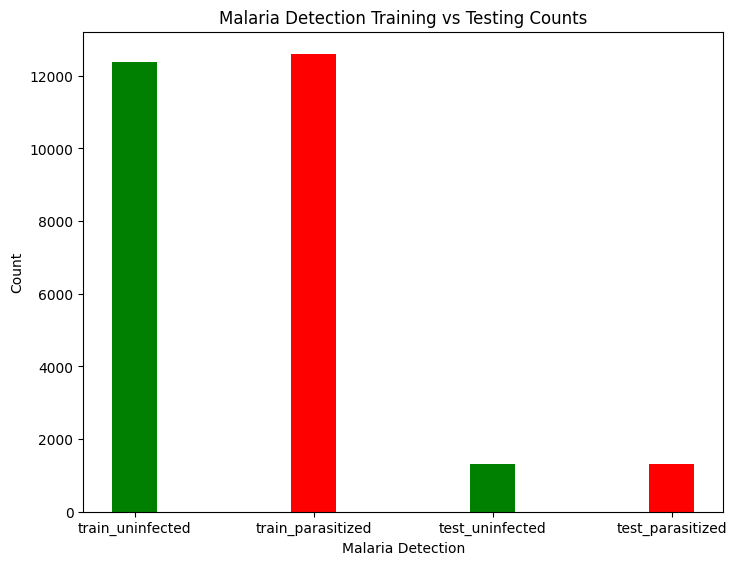

In [12]:
# set width of bar
barWidth = 0.25
fig = plt.figure()

# creating the bar plot
ax = fig.add_axes([0,0,1,1])
X_label = ['train_uninfected', 'train_parasitized', 'test_uninfected', 'test_parasitized']
y_label = []

uninfected_cnt = 0
parasitized_cnt = 0

test_uninfected_cnt = 0
test_parasitized_cnt = 0

for i in range(len(train_class)):
      if (train_class[i] == 0):
        uninfected_cnt += 1
for i in range(len(train_class)):
      if (train_class[i] == 1):
        parasitized_cnt += 1

for i in range(len(test_class)):
      if (test_class[i] == 0):
        test_uninfected_cnt += 1
for i in range(len(test_class)):
      if (test_class[i] == 1):
        test_parasitized_cnt += 1

y_label.append(uninfected_cnt)
y_label.append(parasitized_cnt)

y_label.append(test_uninfected_cnt)
y_label.append(test_parasitized_cnt)

# Make the plot

print(y_label)
#ax.bar(X_label,y_label)
ax.bar(X_label[0],y_label[0], color = 'g', width = 0.25)
ax.bar(X_label[1],y_label[1], color = 'r', width = 0.25)
ax.bar(X_label[2],y_label[2], color = 'g', width = 0.25)
ax.bar(X_label[3],y_label[3], color = 'r', width = 0.25)
plt.xlabel("Malaria Detection")
plt.ylabel("Count")
plt.title("Malaria Detection Training vs Testing Counts")
plt.show()


####<b> Observations and insights: </b>
We have 12582 training images for parasitized and 12376 images for uninfected type.The testing images have 1300 each for uninfected and parasitized.
We have 206 more training images for parasitized than the uninfected images.
The training data is not balanced while the test data is balanced.
It is preferrable to have a balanced data for training,but the difference in the two types(206) is not too much to cause a significant reduction in accuracy.I'll train the model to evaluate the performance and see how it goes.

### <b>Data Exploration</b>
Let's visualize the images from the train data

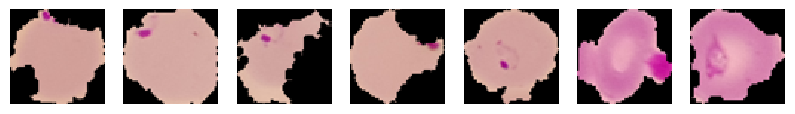

In [13]:
fig = plt.figure(figsize=(10, 10))

for i in range(7):
  ax = plt.subplot(1, 7,i+1)
  ax.axis('Off')
  plt.imshow(train_images[i], interpolation='nearest')


####<b> Observations and insights: </b>
The infected cell images have a patch of dark area that shows the infections.The uninfected cells don't have this which is evident in the 36 image subplot in the next cell below this that shows both types.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

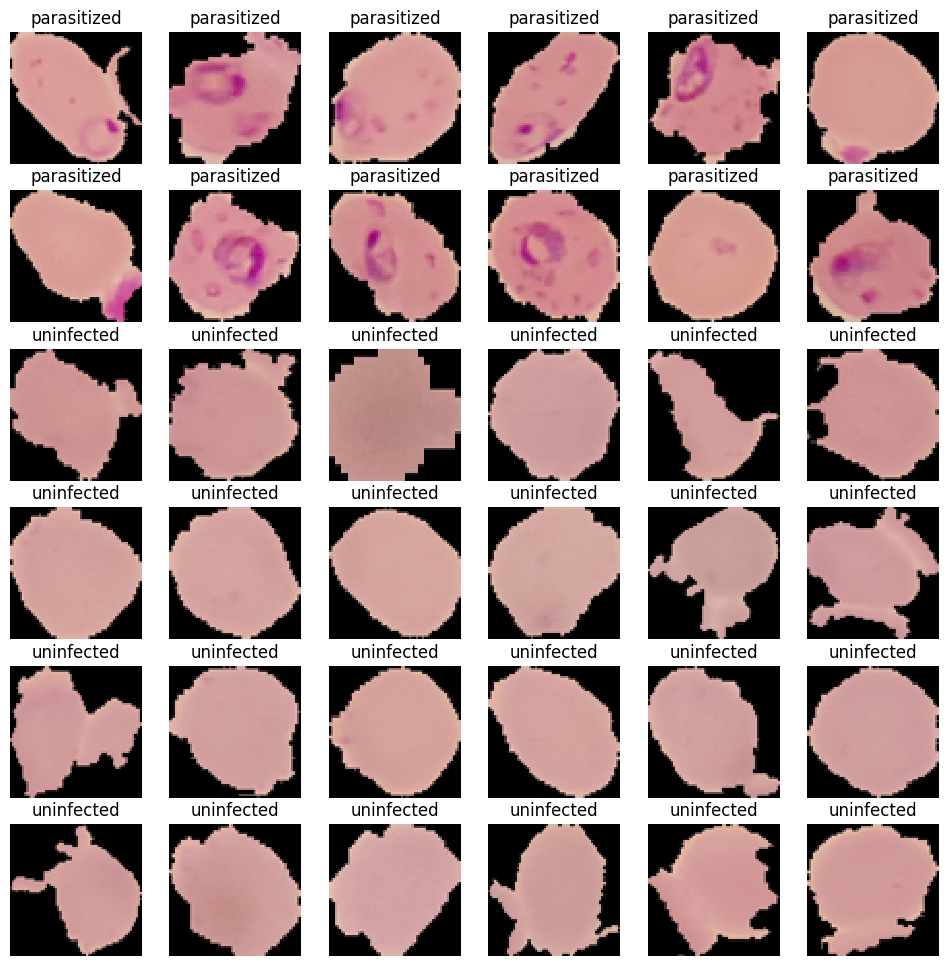

In [14]:
fig = plt.figure(figsize=(12, 12))

data = []
classes = []
for i in range(12570,12606):
  data.append(train_images[i])
  classes.append(train_class[i])

for i in range(len(data)):
    ax = plt.subplot(6, 6,i+1)
    ax.axis('Off')
    plt.imshow(data[i], interpolation='nearest')
    if(classes[i]==1):
      plt.title('parasitized')
    if(classes[i]==0):
      plt.title('uninfected')
    plt.plot(6,6)



####<b>Observations and insights:

###<b> Plotting the mean images for parasitized and uninfected

In [15]:
parasitized_images = []
uninfected_images = []

mean_inf_img = []
mean_uninf_img = []

def create_ds():
  for i in range(len(train_class)):
      if train_class[i] == 1:
        parasitized_images.append(train_images[i])

  for i in range(len(train_class)):
      if train_class[i] == 0:
        uninfected_images.append(train_images[i])

create_ds()
# # Function to plot the mean image

def calc_mean_image(label):

  if label == 1.0:
    mean_inf_img = np.mean(parasitized_images,axis=0)
    plt.imshow(mean_inf_img)
    plt.title('Mean Image: Parasitized')
  if label == 0.0:
    mean_uninf_img = np.mean(uninfected_images,axis=0)
    plt.imshow(mean_uninf_img)
    plt.title('Mean Image: Uninfected')

<b> Mean image for parasitized

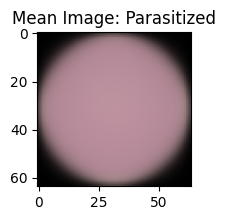

In [16]:
fig = plt.figure(figsize=(2, 2))
calc_mean_image(1.0)


<b> Mean image for uninfected

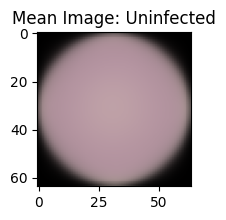

In [17]:
fig = plt.figure(figsize=(2, 2))
calc_mean_image(0.0)



####<b> Observations and insights: </b>
The mean image for parasitized and uninfected images are plotted above and we can see that there is a slight increase in the intensity of color for parasitized images compared to the uninfected images.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [18]:
import cv2

# Function rgb2hsv to convert images from RGB to HSV

def rgb2hsv(images,classes):
  fig = plt.figure(figsize=(12, 12))
  hsv_array = []
  class_array = []
  for i in range(len(images)):
    hsv = cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)
    hsv_array.append(hsv)
    class_array.append(classes[i])

  for i in range(36):
    ax = plt.subplot(6, 6,i+1)
    ax.axis('Off')
    plt.imshow((hsv_array[i] * 255).astype(np.uint8))
 #   plt.imshow(hsv_array[i], interpolation='nearest')
    if(class_array[i]==1):
      plt.title('parasitized')
    if(class_array[i]==0):
      plt.title('uninfected')
    plt.plot(6,6)
  return hsv_array,class_array

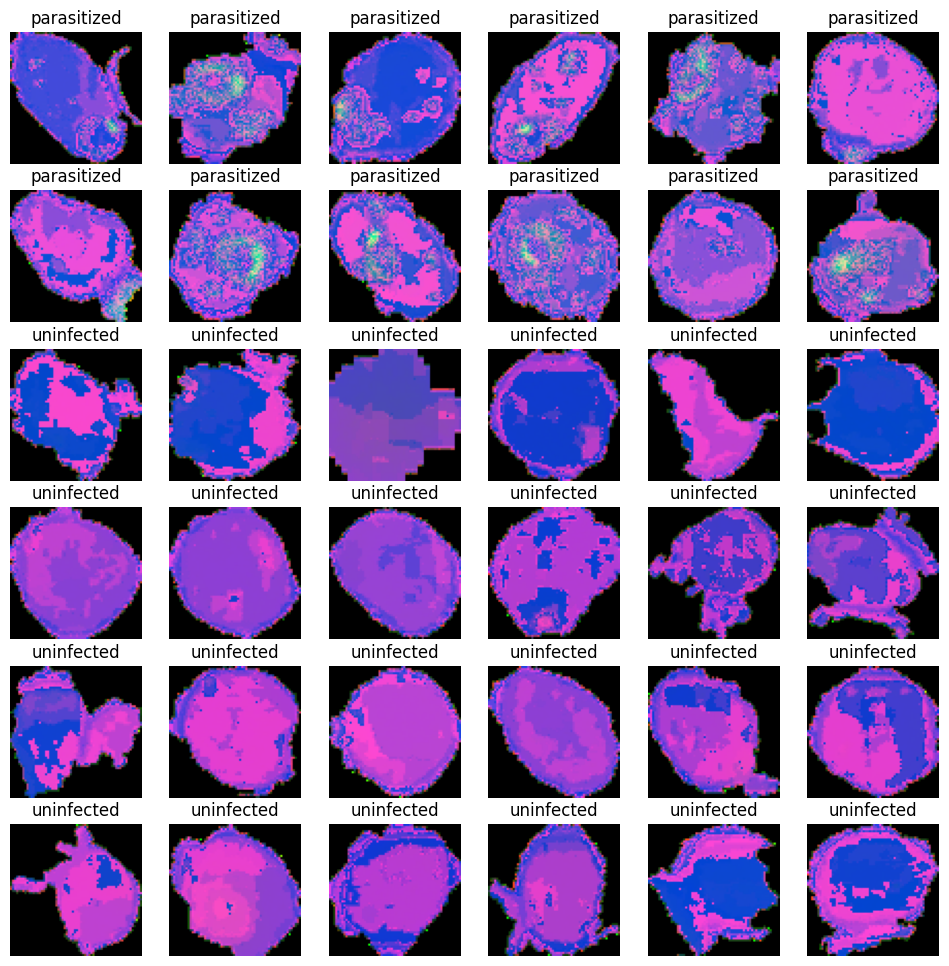

In [19]:
sample_train_images = []
sample_train_class = []
for i in range(12570,12606):
  sample_train_images.append(train_images[i])
  sample_train_class.append(train_class[i])

hsv_train_images,hsv_train_class = rgb2hsv(sample_train_images,sample_train_class)


###<b> Converting the test data

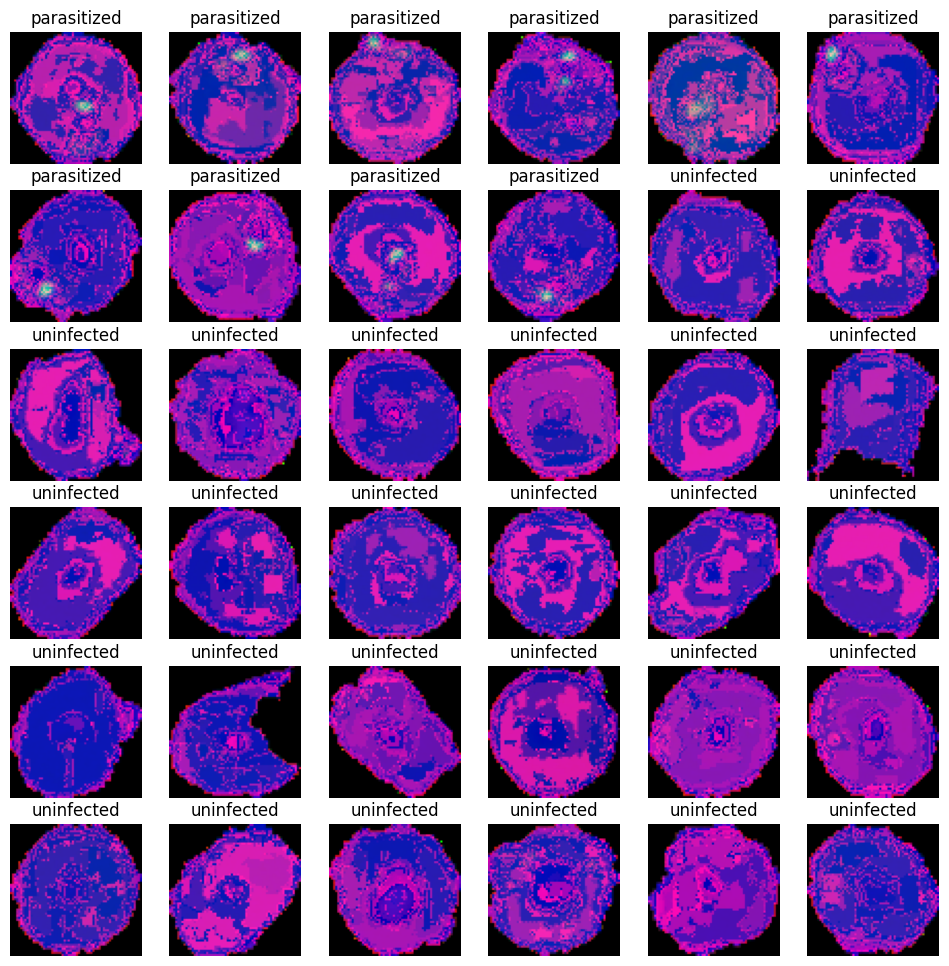

In [20]:
sample_test_images = []
sample_test_class = []
for i in range(1290,1326):
  sample_test_images.append(test_images[i])
  sample_test_class.append(test_class[i])

hsv_test_images,hsv_test_class = rgb2hsv(sample_test_images,sample_test_class)

####<b>Observations and insights: </b>
We can observe the infections clearly in a lighter shade of "white" patches in the hsv version of the training images.The uninfected images does not have this patch.
It can be seen that converting to hsv have added more noise to the images and may not be helpful in getting accuracy for our models.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [21]:
# Function to apply gaussian blur on images

def gaussian_blur(images,classes):
  fig = plt.figure(figsize=(12, 12))
  gbr_array = []
  class_array = []
  for i in range(len(images)):
    gbr = cv2.GaussianBlur(images[i], (5, 5), 0)
    gbr_array.append(gbr)
    class_array.append(classes[i])

  for i in range(36):
    ax = plt.subplot(6, 6,i+1)
    ax.axis('Off')
    plt.imshow(gbr_array[i])
 #   plt.imshow(gbr_array[i], interpolation='nearest')
    if(class_array[i]==1):
      plt.title('parasitized')
    if(class_array[i]==0):
      plt.title('uninfected')
    plt.plot(6,6)
  return gbr_array,class_array

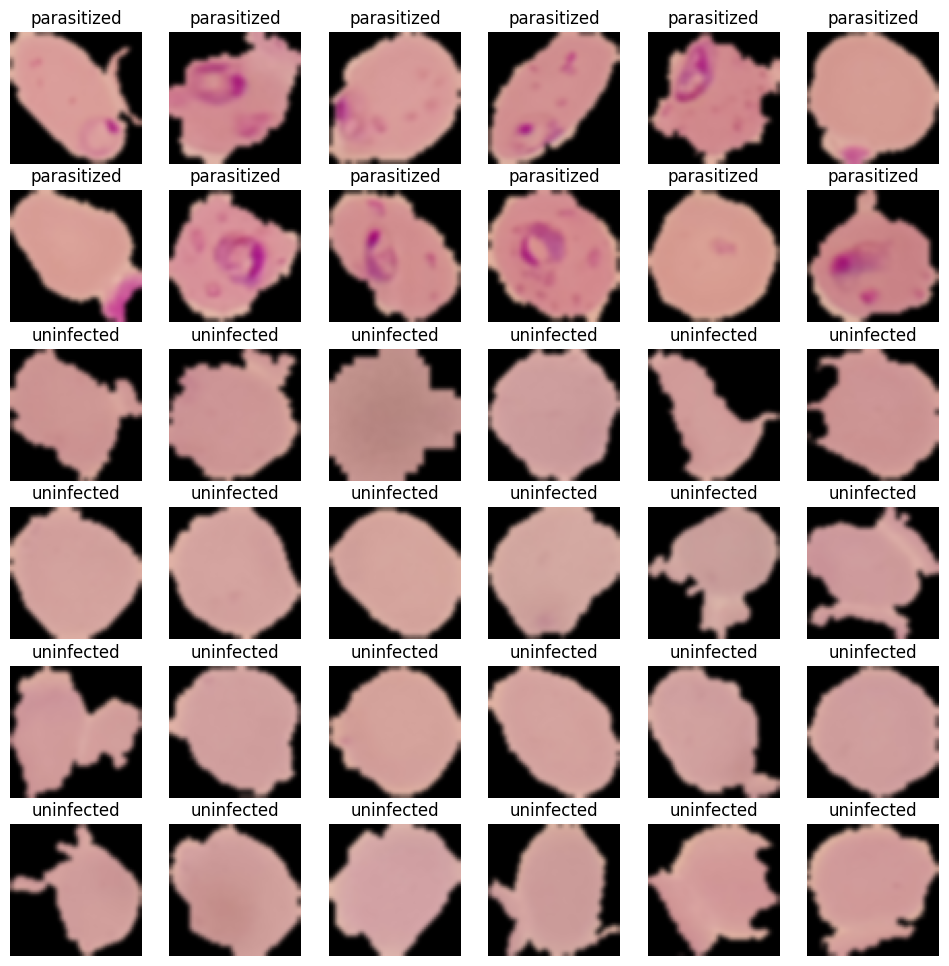

In [22]:
sample_train_images_gbr = []
sample_train_class_gbr = []
for i in range(12570,12606):
  sample_train_images_gbr.append(train_images[i])
  sample_train_class_gbr.append(train_class[i])

gbr_train_images,gbr_train_class = gaussian_blur(sample_train_images_gbr,sample_train_class_gbr)

###<b> Gaussian Blurring on test data

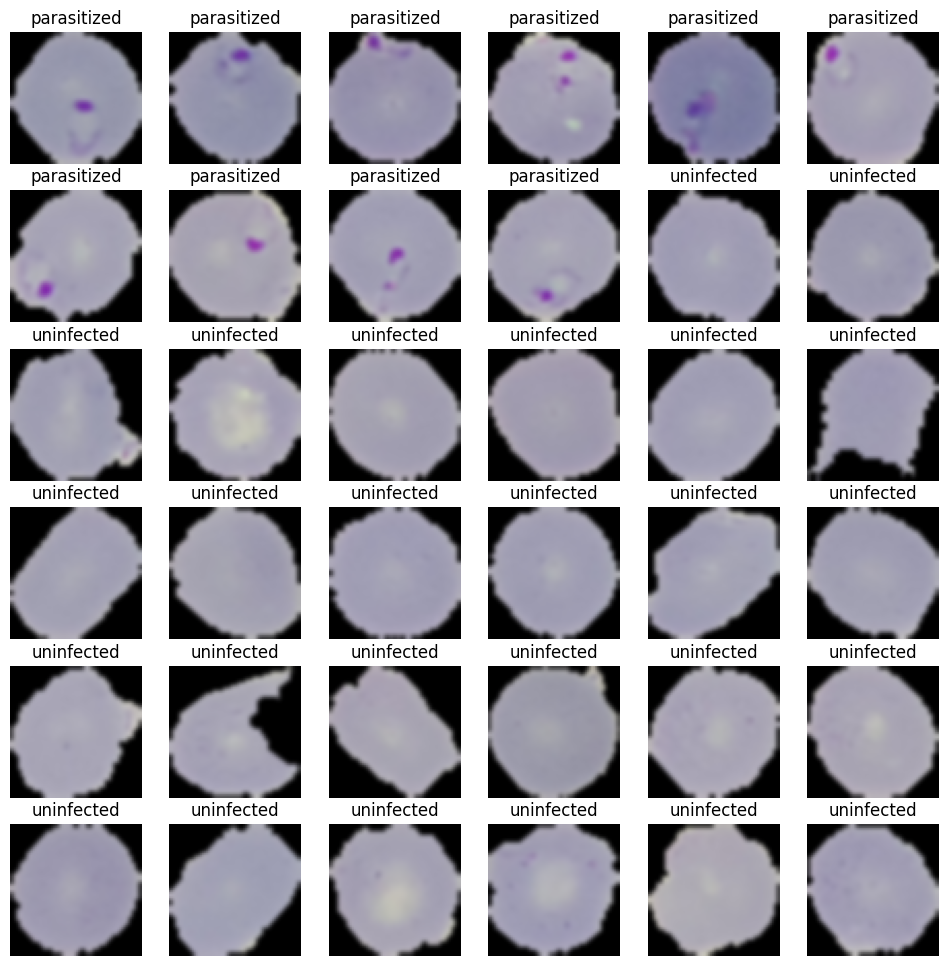

In [23]:
sample_test_images_gbr = []
sample_test_class_gbr = []
for i in range(1290,1326):
  sample_test_images_gbr.append(test_images[i])
  sample_test_class_gbr.append(test_class[i])

gbr_test_images,gbr_test_class = gaussian_blur(sample_test_images_gbr,sample_test_class_gbr)

####<b>Observations and insights:</b>

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

Gaussian blurring is effective is smoothing the image and reduce noise and much detail.It is like viewing the image through a translucent screen.It also reduced the standard deviation of pixel values in the image.

I'll evaluate the model performance without using the blurring and see how it performs and later analyse the impact of using the blurred images for retraining the best CNN model.

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [24]:

# For Model Building
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model # Sequential api for sequential model

# Clearing backend
from tensorflow.keras import backend

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle


####<B>One Hot Encoding the train and test labels

In [25]:
# For classification problem,we have already categorized the outputs as binary, i.e, either 0 or 1.
# The First model will use sigmoid activation and see results without any encoding of target variables.
train_class = train_class.astype('float32')
test_class = test_class.astype('float32')
train_class = np.array(train_class)
test_class = np.array(test_class)
print(train_class.dtype)
print(test_class.dtype)
print(train_class[0])
print(test_class[0])

float32
float32
1.0
1.0


In [26]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

###<b> Building the model

In [27]:
cnn_model_1 = Sequential()
cnn_model_1.add(Conv2D(64, (2,2), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
cnn_model_1.add(MaxPooling2D(2,2))
cnn_model_1.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_1.add(MaxPooling2D(2,2))
cnn_model_1.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_1.add(MaxPooling2D(2,2))
cnn_model_1.add(BatchNormalization()),
cnn_model_1.add(Flatten())
cnn_model_1.add(Dense(64, activation='relu'))
cnn_model_1.add(Dense(32, activation='relu'))
cnn_model_1.add(Dense(32, activation='relu'))
cnn_model_1.add(Dense(1, activation='sigmoid'))
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

###<b> Compiling the model

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model_1.compile(loss = 'binary_crossentropy',optimizer=opt,metrics=['accuracy'])

<b> Using Callbacks

In [29]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
# This callback will stop the training when there is no improvement in
# the loss for four consecutive epochs.

<b> Fit and train our Model

In [30]:
history1 = cnn_model_1.fit(train_images,train_class, batch_size = 32, shuffle=True, validation_split = 0.2, epochs = 40, verbose = 1, callbacks=my_callbacks)

Epoch 1/40
624/624 [==============================] - 18s 9ms/step - loss: 0.3099 - accuracy: 0.8536 - val_loss: 0.5859 - val_accuracy: 0.7564
Epoch 2/40
624/624 [==============================] - 4s 7ms/step - loss: 0.0826 - accuracy: 0.9725 - val_loss: 0.0812 - val_accuracy: 0.9786
Epoch 3/40
624/624 [==============================] - 4s 7ms/step - loss: 0.0675 - accuracy: 0.9769 - val_loss: 0.1837 - val_accuracy: 0.9389
Epoch 4/40
624/624 [==============================] - 5s 7ms/step - loss: 0.0611 - accuracy: 0.9793 - val_loss: 0.1394 - val_accuracy: 0.9465
Epoch 5/40
624/624 [==============================] - 4s 7ms/step - loss: 0.0561 - accuracy: 0.9811 - val_loss: 0.1019 - val_accuracy: 0.9629
Epoch 6/40
624/624 [==============================] - 4s 7ms/step - loss: 0.0469 - accuracy: 0.9838 - val_loss: 0.1944 - val_accuracy: 0.9305
Epoch 7/40
624/624 [==============================] - 5s 9ms/step - loss: 0.0441 - accuracy: 0.9848 - val_loss: 0.1957 - val_accuracy: 0.9147
Epoch

###<b> Evaluating the model on test data

In [31]:
accuracy = cnn_model_1.evaluate(test_images,test_class)
print(accuracy)
print('Accuracy of model on Test Data: ','{:.2f}%'.format(accuracy[1]*100))

82/82 [==============================] - 1s 5ms/step - loss: 0.1611 - accuracy: 0.9758
[0.16113466024398804, 0.9757692217826843]
Accuracy of model on Test Data:  97.58%


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
Prediction first test image: 1.0
Actual Class of first image: 1.0
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1300
         1.0       0.97      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



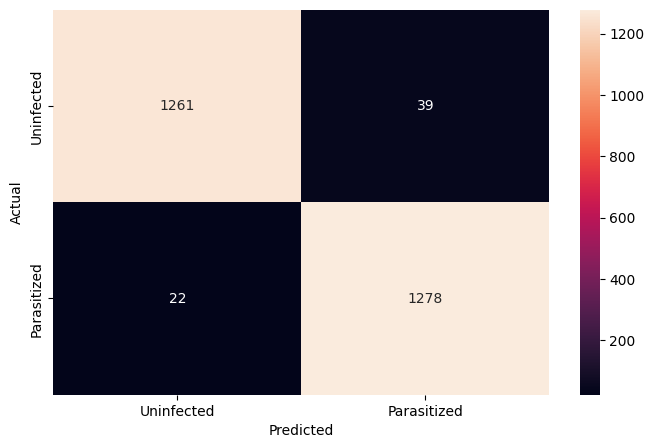

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Function to get the predictions from Sigmoid using a threshold of :
#     > 0.7 for true classification and
#     < 0.7 for false classification

def prediction(images):
  pred_class = []
  predictions = cnn_model_1.predict(images)
  for i, predicted in enumerate(predictions):
    if predictions[i] > 0.7:
        pred_class.append(1.0)
    else:
        pred_class.append(0.0)
  return pred_class

pred_class = prediction(test_images)
print('Prediction first test image:',pred_class[0])
print('Actual Class of first image:',test_class[0])
# Printing the classification report
print(classification_report(test_class, pred_class))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(test_class, pred_class)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

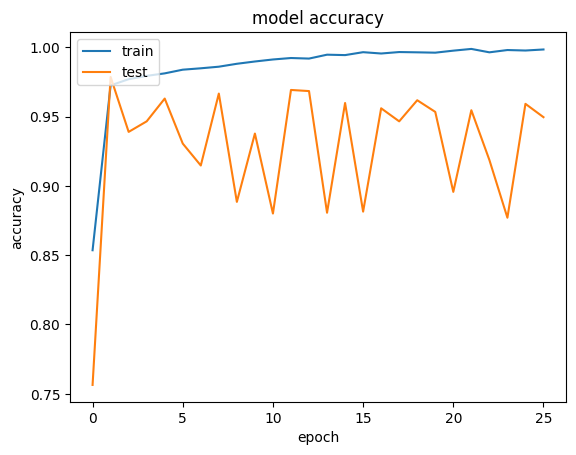

In [33]:
# Function to plot train and validation accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [34]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [35]:
# For the second CNN model,I want to one hot encode the training and testing labels
train_class_encoded = to_categorical(train_class,2)
test_class_encoded = to_categorical(test_class,2)

###<b> Building the Model

In [36]:
# For the second CNN model,I've added Dropout layers to prevent the model from overfitting the training data
# The models output layer uses softmax activation instead of sigmoid
cnn_model_2 = Sequential()
cnn_model_2.add(Conv2D(64, (2,2), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Dropout(0.2))
cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(64, activation='relu'))
cnn_model_2.add(Dropout(0.2))
cnn_model_2.add(Dense(32, activation='relu'))
cnn_model_2.add(Dense(32, activation='relu'))
cnn_model_2.add(Dense(2, activation='softmax'))
cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

###<b> Compiling the model

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model_2.compile(loss = 'categorical_crossentropy',optimizer=opt,metrics= "accuracy")

<b> Using Callbacks

In [38]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
# This callback will stop the training when there is no improvement in
# the loss for four consecutive epochs.


<b>Fit and Train the model

In [39]:
history2 = cnn_model_2.fit(train_images,train_class_encoded, batch_size = 64, shuffle=True, validation_split = 0.2, epochs = 100, verbose = 1, callbacks=my_callbacks)

Epoch 1/100
312/312 [==============================] - 8s 16ms/step - loss: 0.3420 - accuracy: 0.8374 - val_loss: 0.1124 - val_accuracy: 0.9623
Epoch 2/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0653 - accuracy: 0.9771 - val_loss: 0.0942 - val_accuracy: 0.9635
Epoch 3/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0561 - accuracy: 0.9804 - val_loss: 0.0794 - val_accuracy: 0.9698
Epoch 4/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0504 - accuracy: 0.9821 - val_loss: 0.1557 - val_accuracy: 0.9321
Epoch 5/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0477 - accuracy: 0.9823 - val_loss: 0.1077 - val_accuracy: 0.9589
Epoch 6/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0478 - accuracy: 0.9829 - val_loss: 0.1536 - val_accuracy: 0.9437
Epoch 7/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0465 - accuracy: 0.9827 - val_loss: 0.0863 - val_accuracy:

###<b> Evaluating the model

In [40]:
# Evaluate the 2nd model's performance on the test data.
accuracy_model_2 = cnn_model_2.evaluate(test_images,test_class_encoded)
print(accuracy_model_2)
print('Accuracy of model # 2 on Test Data: ','{:.2f}%'.format(accuracy_model_2[1]*100))

82/82 [==============================] - 1s 4ms/step - loss: 0.0915 - accuracy: 0.9838
[0.09151239693164825, 0.983846127986908]
Accuracy of model # 2 on Test Data:  98.38%


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



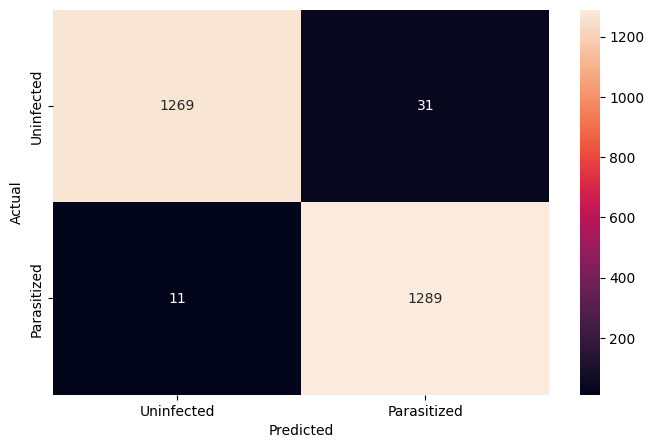

In [41]:
pred_class = cnn_model_2.predict(test_images)

pred_class = np.argmax(pred_class,axis=1)
true_class = np.argmax(test_class_encoded,axis=1)
print(classification_report(true_class, pred_class))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(true_class, pred_class)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the train and the validation curves

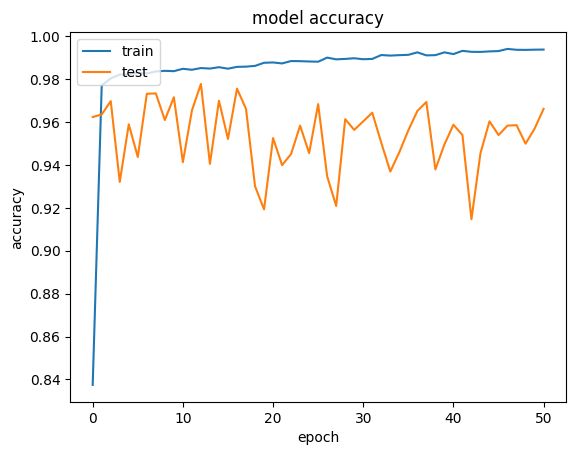

In [42]:
# Plot train and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

In [43]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

###<b> Model 2 with Batch Normalization

In [44]:
from keras.layers import LeakyReLU

cnn_model_3 = Sequential()
cnn_model_3.add(Conv2D(32, (2,2), input_shape=(64, 64, 3), activation=LeakyReLU(alpha=0.01), padding = 'same'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Dropout(0.2))
cnn_model_3.add(Conv2D(32, (2,2), activation=LeakyReLU(alpha=0.01), padding = 'same'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Conv2D(32, (2,2), activation=LeakyReLU(alpha=0.1), padding = 'same'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Conv2D(32, (2,2), activation=LeakyReLU(alpha=0.1), padding = 'same'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Dropout(0.2))
cnn_model_3.add(BatchNormalization()),
cnn_model_3.add(Flatten())
cnn_model_3.add(Dense(128, activation=LeakyReLU(alpha=0.01)))
cnn_model_3.add(Dropout(0.2))
cnn_model_3.add(Dense(64, activation=LeakyReLU(alpha=0.01)))
cnn_model_3.add(Dropout(0.2))
cnn_model_3.add(Dense(64, activation=LeakyReLU(alpha=0.01)))
cnn_model_3.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
cnn_model_3.add(Dense(2, activation='softmax'))

###<b> Building the Model

In [45]:
cnn_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4

###<b>Compiling the model

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model_3.compile(loss = 'categorical_crossentropy',optimizer=opt,metrics= "accuracy")

<b> Using callbacks

In [47]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

<b>Fit and train the model

In [48]:
history3 = cnn_model_3.fit(train_images,train_class_encoded, batch_size = 32, shuffle=True, validation_split = 0.2, epochs = 100, verbose = 1, callbacks=my_callbacks)

Epoch 1/100
624/624 [==============================] - 9s 9ms/step - loss: 0.3497 - accuracy: 0.8249 - val_loss: 0.1160 - val_accuracy: 0.9726
Epoch 2/100
624/624 [==============================] - 5s 8ms/step - loss: 0.0900 - accuracy: 0.9705 - val_loss: 0.0783 - val_accuracy: 0.9794
Epoch 3/100
624/624 [==============================] - 5s 8ms/step - loss: 0.0771 - accuracy: 0.9747 - val_loss: 0.0970 - val_accuracy: 0.9669
Epoch 4/100
624/624 [==============================] - 5s 8ms/step - loss: 0.0697 - accuracy: 0.9770 - val_loss: 0.2148 - val_accuracy: 0.8946
Epoch 5/100
624/624 [==============================] - 5s 8ms/step - loss: 0.0679 - accuracy: 0.9780 - val_loss: 0.0718 - val_accuracy: 0.9688
Epoch 6/100
624/624 [==============================] - 5s 8ms/step - loss: 0.0640 - accuracy: 0.9784 - val_loss: 0.0944 - val_accuracy: 0.9685
Epoch 7/100
624/624 [==============================] - 5s 8ms/step - loss: 0.0593 - accuracy: 0.9798 - val_loss: 0.0518 - val_accuracy: 0.9764

<b>Plotting the train and validation accuracy

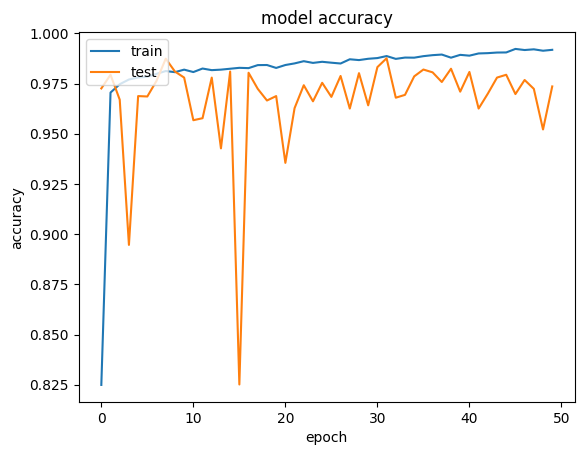

In [49]:
# Plot train and validation accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


###<b>Evaluating the model

In [50]:
# Evaluate the 3rd model's performance on the test data.
accuracy_model_3 = cnn_model_3.evaluate(test_images,test_class_encoded)
print(accuracy_model_3)
print('Accuracy of model # 3 on Test Data: ','{:.2f}%'.format(accuracy_model_3[1]*100))

82/82 [==============================] - 1s 6ms/step - loss: 0.0616 - accuracy: 0.9854
[0.06160619109869003, 0.9853846430778503]
Accuracy of model # 3 on Test Data:  98.54%


####<b>Observations and insights: </b>
CNN Model # 3 is a complex model with 93K trainable parameters and uses dropouts and batch normalization in the convolution layers and the dense layers using a large number of neurons compared to model # 2,but there is no significant improvement in accuracy(98.38% for Model # 2 on test data and 98.54% for Model # 3 on same test data)

The Model # 2 and 3 seems to be generelizing better on test data but Model # 2 has a better recall score(99%) for parasitized which means its not missing the infected cells.It misclassified only 11 out of 1300 infected cells which is very good.  

<b> Generate the classification report and confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



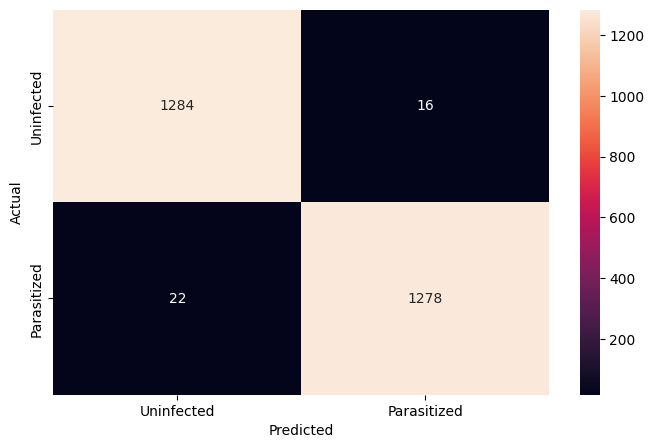

In [51]:
pred_class = cnn_model_3.predict(test_images)

pred_class = np.argmax(pred_class,axis=1)
true_class = np.argmax(test_class_encoded,axis=1)
print(classification_report(true_class, pred_class))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(true_class, pred_class)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [52]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

###<b> Use image data generator

In [53]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_images, train_class_encoded, test_size = 0.2, random_state = 42)

train_datagen = ImageDataGenerator(
    height_shift_range=0.5,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=[0.5,1.0]
    )
val_datagen  = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size = 32, seed = 42, shuffle = True)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 32, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

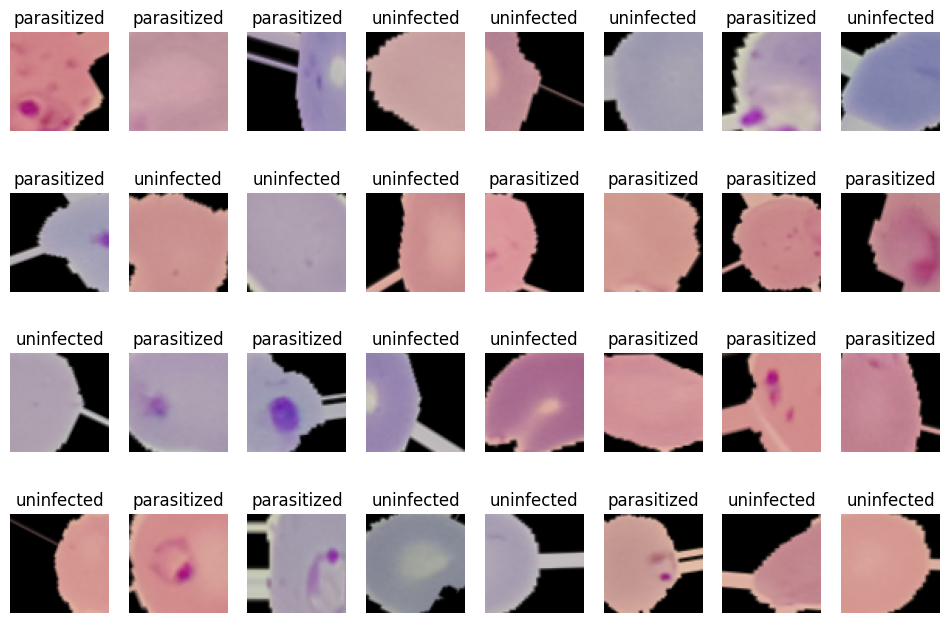

In [54]:
# Visualizing Augmented images using ImageDataGenerator
fig = plt.figure(figsize=(12, 8))
images, labels = next(train_generator)

for i in range(32):
    ax = plt.subplot(4,8,i+1)
    plt.imshow(images[i])
    if(np.argmax(labels[i])==1):
      plt.title('parasitized')
    if(np.argmax(labels[i])==0):
      plt.title('uninfected')
    plt.axis('off')
    plt.plot(8,8)



####<b>Observations and insights: ____

###<b>Building the Model

In [55]:
cnn_model_4 = Sequential()
cnn_model_4.add(Conv2D(32, (2,2), input_shape=(64, 64, 3), activation='relu', padding = 'same'))
cnn_model_4.add(MaxPooling2D(2,2))
cnn_model_4.add(Dropout(0.2))
cnn_model_4.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_4.add(MaxPooling2D(2,2))
cnn_model_4.add(Conv2D(32, (2,2), activation='relu', padding = 'same'))
cnn_model_4.add(MaxPooling2D(2,2))
cnn_model_4.add(Dropout(0.2))
cnn_model_4.add(BatchNormalization()),
cnn_model_4.add(Flatten())
cnn_model_4.add(Dense(128, activation='relu'))
cnn_model_4.add(Dropout(0.2))
cnn_model_4.add(Dense(64, activation='relu'))
cnn_model_4.add(Dropout(0.2))
cnn_model_4.add(Dense(64, activation='relu'))
cnn_model_4.add(Dense(32, activation='relu'))
cnn_model_4.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model_4.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = "accuracy")
cnn_model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4

<b>Using Callbacks

In [56]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

<b> Fit and Train the model

In [57]:
history4 = cnn_model_4.fit(train_generator,validation_data = val_generator, batch_size=32,shuffle=True, epochs = 40, verbose = 1, callbacks=my_callbacks)

Epoch 1/40
624/624 [==============================] - 27s 39ms/step - loss: 0.5634 - accuracy: 0.7002 - val_loss: 0.2325 - val_accuracy: 0.9171
Epoch 2/40
624/624 [==============================] - 23s 38ms/step - loss: 0.3921 - accuracy: 0.8225 - val_loss: 0.1441 - val_accuracy: 0.9571
Epoch 3/40
624/624 [==============================] - 23s 37ms/step - loss: 0.3541 - accuracy: 0.8447 - val_loss: 0.1409 - val_accuracy: 0.9750
Epoch 4/40
624/624 [==============================] - 23s 37ms/step - loss: 0.3424 - accuracy: 0.8529 - val_loss: 0.1215 - val_accuracy: 0.9788
Epoch 5/40
624/624 [==============================] - 23s 38ms/step - loss: 0.3366 - accuracy: 0.8519 - val_loss: 0.1113 - val_accuracy: 0.9800
Epoch 6/40
624/624 [==============================] - 24s 38ms/step - loss: 0.3295 - accuracy: 0.8590 - val_loss: 0.1194 - val_accuracy: 0.9786
Epoch 7/40
624/624 [==============================] - 24s 38ms/step - loss: 0.3322 - accuracy: 0.8572 - val_loss: 0.1066 - val_accuracy:

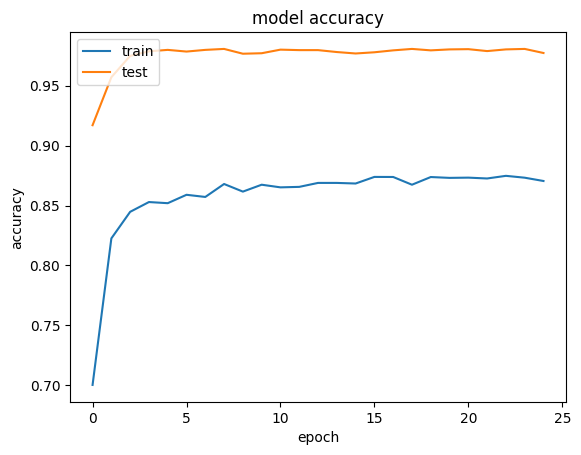

In [58]:
# Plot train and validation accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###<B>Evaluating the model

<b>Plot the train and validation accuracy

In [59]:
# Evaluate the 4rth model's performance on the test data.
accuracy_model_4 = cnn_model_4.evaluate(test_images,test_class_encoded)
print(accuracy_model_4)
print('Accuracy of model # 4 on Test Data: ','{:.2f}%'.format(accuracy_model_4[1]*100))

82/82 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9785
[0.07588502764701843, 0.9784615635871887]
Accuracy of model # 4 on Test Data:  97.85%


<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



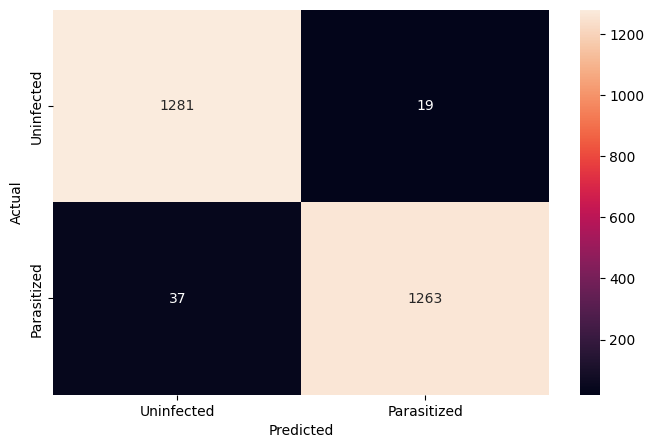

In [60]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred_class = cnn_model_4.predict(test_images)

pred_class = np.argmax(pred_class,axis=1)
true_class = np.argmax(test_class_encoded,axis=1)
print(classification_report(true_class, pred_class))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(true_class, pred_class)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [61]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [62]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))
vgg16_model.trainable = False ## Not trainable weights

from tensorflow.keras import layers, models

norm_layer = layers.BatchNormalization()
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(128, activation='relu')
drop_out_layer_1 = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(64, activation='relu')
drop_out_layer_2 = layers.Dropout(0.2)
dense_layer_3 = layers.Dense(32, activation='relu')
drop_out_layer_3 = layers.Dropout(0.1)
prediction_layer = layers.Dense(2, activation='softmax')

cnn_model_5 = models.Sequential([
    vgg16_model,
    norm_layer,
    flatten_layer,
    dense_layer_1,
    drop_out_layer_1,
    dense_layer_2,
    drop_out_layer_2,
    dense_layer_3,
    drop_out_layer_3,
    prediction_layer
])

cnn_model_5.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                82

###<b>Compiling the model

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model_5.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

<b> using callbacks

In [64]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

<b>Fit and Train the model

In [65]:
# Pulling a single large batch of random testing data for testing after each epoch
x_test, y_test = val_generator.next()
history5 = cnn_model_5.fit(train_generator,validation_data=(x_test, y_test),shuffle=True, epochs = 100, verbose = 1, callbacks=my_callbacks)

Epoch 1/100
624/624 [==============================] - 28s 41ms/step - loss: 0.4937 - accuracy: 0.7550 - val_loss: 0.3967 - val_accuracy: 0.8125
Epoch 2/100
624/624 [==============================] - 24s 38ms/step - loss: 0.4371 - accuracy: 0.7913 - val_loss: 0.2894 - val_accuracy: 0.8750
Epoch 3/100
624/624 [==============================] - 24s 38ms/step - loss: 0.4204 - accuracy: 0.8012 - val_loss: 0.3331 - val_accuracy: 0.8438
Epoch 4/100
624/624 [==============================] - 24s 39ms/step - loss: 0.4117 - accuracy: 0.8066 - val_loss: 0.2974 - val_accuracy: 0.8125
Epoch 5/100
624/624 [==============================] - 24s 39ms/step - loss: 0.4110 - accuracy: 0.8050 - val_loss: 0.3027 - val_accuracy: 0.8438
Epoch 6/100
624/624 [==============================] - 25s 39ms/step - loss: 0.4068 - accuracy: 0.8059 - val_loss: 0.3230 - val_accuracy: 0.8438
Epoch 7/100
624/624 [==============================] - 24s 38ms/step - loss: 0.4035 - accuracy: 0.8119 - val_loss: 0.3274 - val_ac

<b>Plot the train and validation accuracy

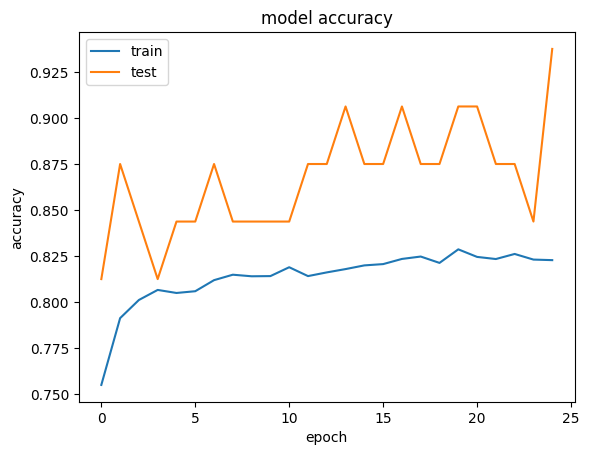

In [66]:
# Plot train and validation accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###**Observations and insights: _____**

*   What can be observed from the validation and train curves?

###<b> Evaluating the model

In [67]:
# Evaluate the 5th model's performance on the test data.
#test_images_from_gen,test_labels_from_gen = next(test_generator)
accuracy_model_5 = cnn_model_5.evaluate(test_images,test_class_encoded)
print(accuracy_model_5)
print('Accuracy of model # 5 on Test Data: ','{:.2f}%'.format(accuracy_model_5[1]*100))


82/82 [==============================] - 2s 19ms/step - loss: 0.2205 - accuracy: 0.9169
[0.22048377990722656, 0.9169231057167053]
Accuracy of model # 5 on Test Data:  91.69%


<b>Plotting the classification report and confusion matrix

82/82 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1300
           1       0.95      0.88      0.91      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



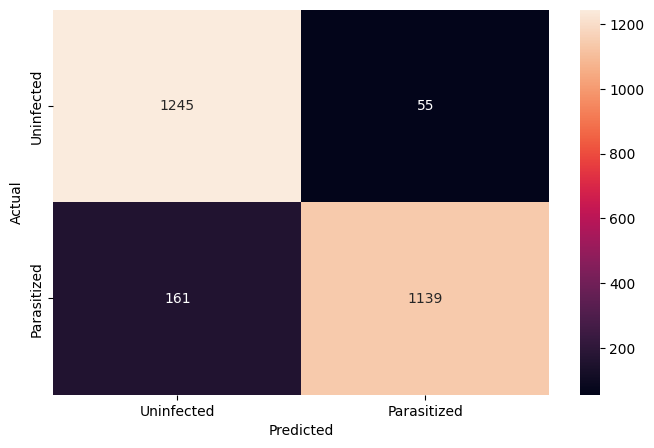

In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred_class = cnn_model_5.predict(test_images)

pred_class = np.argmax(pred_class,axis=1)
true_class = np.argmax(test_class_encoded,axis=1)
print(classification_report(true_class, pred_class))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(true_class, pred_class)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [69]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [70]:
# Function to apply gaussian blur on images
gbr_train_images = []
gbr_train_class = []

def gaussian_blur(images,classes):

  gbr_array = []
  class_array = []
  for i in range(len(images)):
    gbr = cv2.GaussianBlur(images[i], (5, 5), 0)
    gbr_array.append(gbr)
    class_array.append(classes[i])
  return gbr_array,class_array

gbr_train_images,gbr_train_class = gaussian_blur(train_images,train_class_encoded)

In [71]:
gbr_train_images = np.array(gbr_train_images)
gbr_train_class = np.array(gbr_train_class)
print(gbr_train_images.shape)
print(gbr_train_class.shape)

(24958, 64, 64, 3)
(24958, 2)


In [72]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

In [73]:
history_gblur = cnn_model_2.fit(gbr_train_images,gbr_train_class, batch_size = 64, shuffle=True, validation_split = 0.2, epochs = 100, verbose = 1, callbacks=my_callbacks)

Epoch 1/100
312/312 [==============================] - 5s 14ms/step - loss: 0.0302 - accuracy: 0.9889 - val_loss: 0.1885 - val_accuracy: 0.9511
Epoch 2/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0222 - accuracy: 0.9915 - val_loss: 0.3130 - val_accuracy: 0.9209
Epoch 3/100
312/312 [==============================] - 4s 13ms/step - loss: 0.0202 - accuracy: 0.9925 - val_loss: 0.1906 - val_accuracy: 0.9555
Epoch 4/100
312/312 [==============================] - 4s 13ms/step - loss: 0.0212 - accuracy: 0.9920 - val_loss: 0.2390 - val_accuracy: 0.9507
Epoch 5/100
312/312 [==============================] - 4s 14ms/step - loss: 0.0186 - accuracy: 0.9928 - val_loss: 0.1866 - val_accuracy: 0.9607
Epoch 6/100
312/312 [==============================] - 4s 13ms/step - loss: 0.0192 - accuracy: 0.9932 - val_loss: 0.3979 - val_accuracy: 0.9233
Epoch 7/100
312/312 [==============================] - 4s 13ms/step - loss: 0.0162 - accuracy: 0.9942 - val_loss: 0.1651 - val_accuracy:

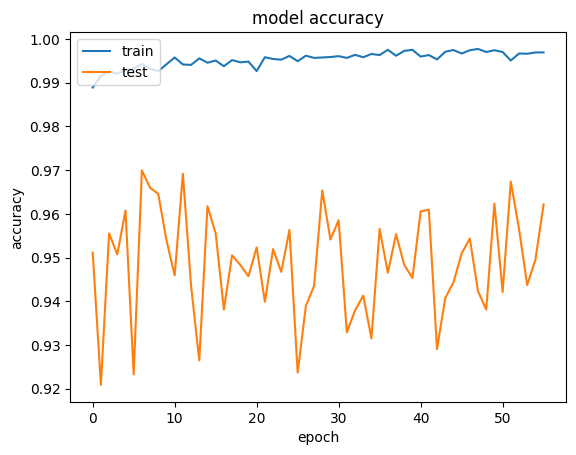

In [74]:
# Plot train and validation accuracy
plt.plot(history_gblur.history['accuracy'])
plt.plot(history_gblur.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
# Evaluate the 2nd model's performance on the test data when trained on blurred images.
accuracy_model_gblur = cnn_model_2.evaluate(test_images,test_class_encoded)
print(accuracy_model_gblur)
print('Accuracy of model # 5 on Test Data: ','{:.2f}%'.format(accuracy_model_gblur[1]*100))

82/82 [==============================] - 0s 4ms/step - loss: 0.2093 - accuracy: 0.9619
[0.2093467116355896, 0.9619230628013611]
Accuracy of model # 5 on Test Data:  96.19%


82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1300
           1       0.94      0.99      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



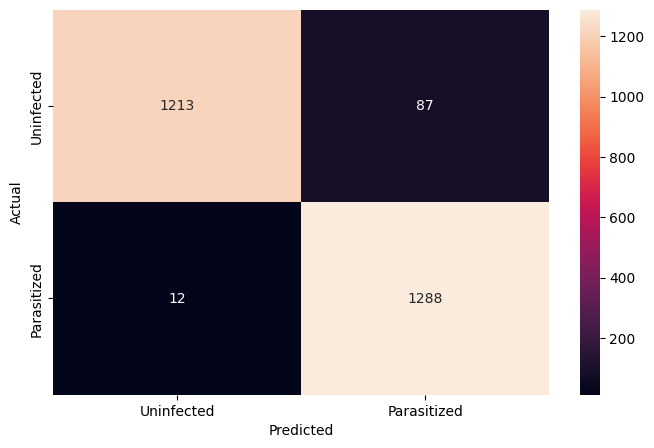

In [76]:
pred_class = cnn_model_2.predict(test_images)

pred_class = np.argmax(pred_class,axis=1)
true_class = np.argmax(test_class_encoded,axis=1)
print(classification_report(true_class, pred_class))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(true_class, pred_class)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [77]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [78]:
# Function rgb2hsv to convert images from RGB to HSV

def rgb2hsv(images,classes):

  hsv_array = []
  class_array = []
  for i in range(len(images)):
    hsv = cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)
    hsv_array.append(hsv)
    class_array.append(classes[i])
  return hsv_array,class_array

In [79]:
hsv_train_images,hsv_train_class = rgb2hsv(train_images,train_class_encoded)

hsv_train_images = np.array(hsv_train_images)
hsv_train_class = np.array(hsv_train_class)
print(hsv_train_images.shape)
print(hsv_train_class.shape)

(24958, 64, 64, 3)
(24958, 2)


In [80]:
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
# This callback will stop the training when there is no improvement in
# the loss for 8 consecutive epochs.

In [81]:
history_hsv = cnn_model_2.fit(hsv_train_images,hsv_train_class, batch_size = 64, shuffle=True, validation_split = 0.2, epochs = 100, verbose = 1, callbacks=my_callbacks)

Epoch 1/100
312/312 [==============================] - 5s 14ms/step - loss: 44.1530 - accuracy: 0.5944 - val_loss: 0.9192 - val_accuracy: 8.0128e-04
Epoch 2/100
312/312 [==============================] - 4s 13ms/step - loss: 0.7333 - accuracy: 0.6277 - val_loss: 0.8873 - val_accuracy: 0.0016
Epoch 3/100
312/312 [==============================] - 4s 13ms/step - loss: 0.7290 - accuracy: 0.6231 - val_loss: 0.9648 - val_accuracy: 2.0032e-04
Epoch 4/100
312/312 [==============================] - 4s 13ms/step - loss: 0.7096 - accuracy: 0.6183 - val_loss: 0.8960 - val_accuracy: 8.0128e-04
Epoch 5/100
312/312 [==============================] - 4s 14ms/step - loss: 0.6751 - accuracy: 0.6276 - val_loss: 1.0446 - val_accuracy: 2.0032e-04
Epoch 6/100
312/312 [==============================] - 4s 13ms/step - loss: 0.6873 - accuracy: 0.6244 - val_loss: 0.9951 - val_accuracy: 2.0032e-04
Epoch 7/100
312/312 [==============================] - 4s 13ms/step - loss: 0.6687 - accuracy: 0.6291 - val_loss: 0

In [82]:
# Evaluate the 2nd model's performance on the test data when trained on HSV images.
accuracy_model_hsv = cnn_model_2.evaluate(test_images,test_class_encoded)
print(accuracy_model_hsv)
print('Accuracy of model # 2 on Test Data: ','{:.2f}%'.format(accuracy_model_hsv[1]*100))

82/82 [==============================] - 0s 4ms/step - loss: 0.7240 - accuracy: 0.5000
[0.7239993810653687, 0.5]
Accuracy of model # 2 on Test Data:  50.00%


###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b> Observations and Conclusions drawn from the final model:</b>
The final model of choise is the CNN model # 2.The model gave an accuracy of 98.38% on test data and produced a recall of 99% for parasitized and 98% on uninfected image detection which indicate that the model is more accurate in predicting the infections than misclassifying the uninfections.

The CNN model # 4 that uses data augmentation is found to generalise well with training and test data but has a recall of 97% and slighly less accurate than Model# 2.This model is also a model of choice due to the fact that the variance on test performance is better than all other models but recall needs to be improved.

The Model # 5 used vgg16 for transfer model,but did not do a good job in providing the accuracy of other simpler CNN models and takes long time to train.


**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

Foe this problem, we want to reduce the number of false negetives for infections as it is dangerous to misclassify an infection as uninfected and the patient could become very vulnerable.I therefore want to recommend a model that gives the best recall for infections and very good overall accuracy and also that which generalise well with test dataset.
The model has an f1-score of 98% which is very good and there is little variation between precision and recall.

I trained several CNN models and found a model (#2) that gave the best recall for infections and also gave a good score for accuracy/f1-score.I also used gaussian blurring and converting the training images to HSV to evaluate the impact of image preprocessing on the model that gave best performance.

I see that the recall score for infections always improve when using gaussian blurring but it does not give a good accuracy as it misclassifies lots of uninfections as infected.

Converting the images to HSV, did very poor on evaluation and test datasets as it increased the "noise" on the image and the model is not able to train well.

It will be necessary to retrain the models when more data becomes available and the model could learn fron new data and can furthur improve the accuracy and recall score.